In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [4]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [6]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect = True)

In [8]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [34]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

/Users/kelcigriffin/anaconda3/envs/dev/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


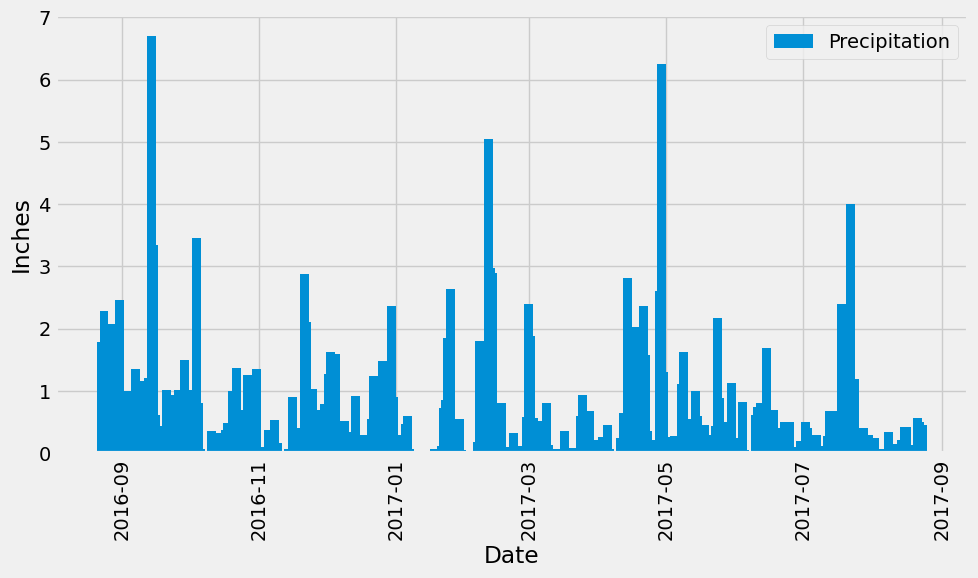

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the most recent date in the dataset.
one_year_ago = dt.date(*map(int, most_recent_date[0].split('-'))) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores for the last 12 months.
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names.
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by='Date')


# Use Pandas Plotting with Matplotlib to plot the data.
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=4, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()




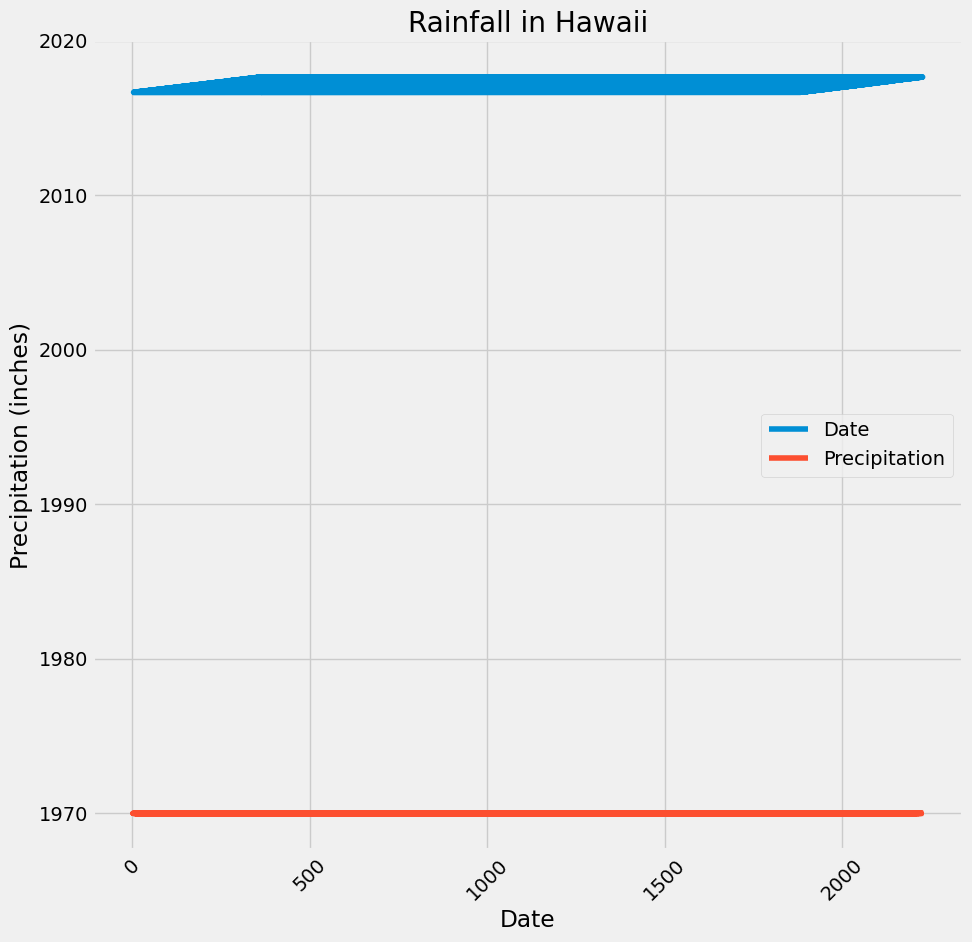

In [41]:
precipitation_df.plot(rot=45, title = "Rainfall in Hawaii", xlabel='Date', ylabel = "Precipitation (inches)", figsize=(10,10))
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()

summary_table = pd.DataFrame({'Precipitation': summary_statistics})
summary_table.index = ['count', 'mean', 'min', '25%', '50%', '75%', 'max', 'std']

print(summary_table)

       Precipitation
count    2021.000000
mean        0.177279
min         0.461190
25%         0.000000
50%         0.000000
75%         0.020000
max         0.130000
std         6.700000


# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number of stations in the dataset
total_count = session.query(Measurement.station).distinct().count()
print(total_count)

9


In [50]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stn = [Measurement.station,
        func.count(Measurement.date)]
station_activity = session.query(*most_active_stn).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs = [Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]
active_station = session.query(*tobs).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in active_station:
     print(station)

('USC00519281', 54.0, 85.0, 71.66378066378067)


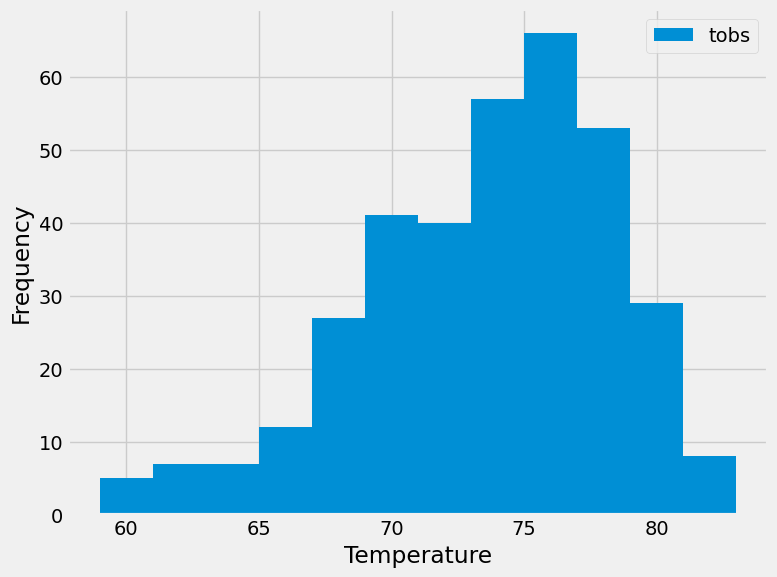

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year from the last date in the data set.
one_year_ago = dt.date(*map(int, most_recent_date[0].split('-'))) - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

plt.show()

# Close Session

In [58]:
# Close Session
session.close()
